In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import math
import operator

from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import matplotlib as mpl
import statistics

import pytz
import us
import datetime as dt

In [194]:
import sqlalchemy
import psycopg2
import simplejson
import os
%load_ext sql
 
%config SqlMagic.displaylimit = 50

with open(os.path.join(os.path.expanduser('~'), ".redshift-creds.json")) as fh:
    creds = simplejson.loads(fh.read())
    
connect_to_db = 'postgresql+psycopg2://' + \
                creds['user_name'] + ':' + creds['password'] + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];
%sql $connect_to_db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: giridhar@dw01'

In [4]:
actFile = '/Users/adgiridhar/Google Drive/PR stories/sleep_data/Activity_cards with demographic data_2018_02_27.csv'

actDf = pd.read_csv(actFile)
actDf = actDf[pd.notnull(actDf['gender'])]
actDf['activity_start'] = pd.to_datetime(actDf['activity_start'])
actDf['activity_end'] = pd.to_datetime(actDf['activity_end'])
actDf['birthdate'] = pd.to_datetime(actDf['birthdate'])

actDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1025359 entries, 0 to 1025358
Data columns (total 13 columns):
Unnamed: 0        1025359 non-null int64
user_id           1025359 non-null object
activity_start    1025359 non-null datetime64[ns]
activity_end      1025359 non-null datetime64[ns]
cardtype          1025359 non-null int64
autocreated       1025359 non-null bool
gender            1025359 non-null object
city              1025359 non-null object
state_name        1025359 non-null object
state_id          1025359 non-null int64
birthdate         1025359 non-null datetime64[ns]
weight            1025359 non-null int64
height            1025359 non-null int64
dtypes: bool(1), datetime64[ns](3), int64(5), object(4)
memory usage: 102.7+ MB


In [5]:
max(actDf['activity_end'])

Timestamp('2018-02-27 16:57:12')

In [6]:
bpmFile = '/Users/adgiridhar/bpm.csv'
bpmDf = pd.read_csv(bpmFile)
bpmDf['epoch_start_date'] = pd.to_datetime(bpmDf['epoch_start_date'])
bpmDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521371 entries, 0 to 17521370
Data columns (total 10 columns):
Unnamed: 0          int64
user_id             object
epoch_start_utc     int64
bpm                 int64
epoch_start_date    datetime64[ns]
epoch_next_utc      float64
gender              object
city                object
state               object
birthdate           object
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 1.3+ GB


In [7]:
max(bpmDf['epoch_start_date'])

Timestamp('2018-12-29 21:59:00')

In [8]:
stepsFile = '/Users/adgiridhar/Google Drive/PR stories/stress_data/Total_steps with demographic data_2018_03_05.csv'
stepsDf = pd.read_csv(stepsFile)
stepsDf = stepsDf[pd.notnull(stepsDf['gender'])]
stepsDf = stepsDf.drop(['age','dailygoal'],axis=1)
stepsDf['step_date'] = pd.to_datetime(stepsDf['step_date'])
stepsDf['birthdate'] = pd.to_datetime(stepsDf['birthdate'])
stepsDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64622 entries, 0 to 65508
Data columns (total 10 columns):
user_id       64622 non-null object
tot_steps     64622 non-null int64
gender        64622 non-null object
step_date     64622 non-null datetime64[ns]
city          64622 non-null object
state_name    64622 non-null object
state_id      64622 non-null int64
birthdate     64622 non-null datetime64[ns]
weight        64622 non-null int64
height        64622 non-null int64
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 5.4+ MB


In [11]:
condition_ = actDf['cardtype']==39
sexTimes = actDf[condition_]
sexTimes = sexTimes.reset_index(drop=True)
sexTimes

Unnamed: 0     user_id      activity_start        activity_end  \
0            217  rb5CiuEd44 2018-02-19 12:40:00 2018-02-19 12:52:00   
1            360  0SH49QgTTz 2018-01-24 03:22:00 2018-01-24 03:34:00   
2           1385  x1LrOefQA2 2018-01-15 04:56:00 2018-01-15 06:23:00   
3           2097  tHo5YaoWus 2017-11-03 03:42:00 2017-11-03 04:12:00   
4           2883  gRELV8R3eJ 2017-11-01 12:15:00 2017-11-01 12:46:00   
5           2956  Vr4EEmTLAd 2018-02-23 16:32:00 2018-02-23 16:46:00   
6           3110  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
7           3111  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
8           4378  TsUSyAzyT1 2017-12-10 05:13:00 2017-12-10 05:25:00   
9           4379  TsUSyAzyT1 2017-12-10 05:13:00 2017-12-10 05:25:00   
10          7713  gRELV8R3eJ 2017-11-04 14:12:00 2017-11-04 15:01:00   
11          7916  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
12          7917  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
13         11209  tHo5YaoWus 2017-11-11 01:15:00 2017-11-11 01:45:00   
14         11481  zAyaz2tOmN 2017-11-15 06:33:00 2017-11-15 06:58:00   
15         13144  FG3EA8i3g4 2017-11-17 04:16:00 2017-11-17 04:43:00   
16         13195  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
17         13196  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
18         13521  m7nrqVFCnB 2017-12-16 05:00:00 2017-12-16 05:11:00   
19         13522  m7nrqVFCnB 2017-12-16 05:00:00 2017-12-16 05:11:00   
20         13523  m7nrqVFCnB 2017-12-16 05:00:00 2017-12-16 05:11:00   
21         13836  974em37LL8 2018-02-13 05:30:00 2018-02-13 06:27:00   
22         13837  974em37LL8 2018-02-13 05:30:00 2018-02-13 06:27:00   
23         14634  hxZ0BFqimO 2017-11-11 22:49:00 2017-11-11 23:42:00   
24         15572  DTlsAtGdzX 2017-11-15 10:47:00 2017-11-15 11:31:00   
25         17747  Xc2JgLxg5L 2018-02-18 13:46:00 2018-02-18 14:14:00   
26         19869  TAvtBjuNx0 2018-02-21 00:52:00 2018-02-21 01:07:00   
27         21465  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
28         21466  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
29         22014  AjHlTaPqMU 2017-11-28 22:58:00 2017-11-28 23:23:00   
...          ...         ...                 ...                 ...   
1641     1009996  yKd7dK8Rs6 2017-12-09 07:32:00 2017-12-09 07:58:00   
1642     1012181  FfTYro8zB8 2018-02-23 06:40:00 2018-02-23 06:52:00   
1643     1013243  bGk7ia1S1J 2017-11-04 12:26:00 2017-11-04 12:45:00   
1644     1013244  bGk7ia1S1J 2017-11-04 12:26:00 2017-11-04 12:45:00   
1645     1014791  DSCUAs5OCi 2018-01-24 03:57:00 2018-01-24 04:27:00   
1646     1014917  LkjY8UXZA1 2017-12-16 13:00:00 2017-12-16 13:19:00   
1647     1016518  lOQdBlsgDh 2017-12-30 05:00:00 2017-12-30 05:10:00   
1648     1017004  bGk7ia1S1J 2018-02-17 03:45:00 2018-02-17 04:15:00   
1649     1017005  bGk7ia1S1J 2018-02-17 03:45:00 2018-02-17 04:15:00   
1650     1019155  vybwsJlfU0 2017-12-14 04:34:00 2017-12-14 04:56:00   
1651     1022129  6N0EbiSLkE 2017-12-17 13:10:00 2017-12-17 13:36:00   
1652     1024258  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1653     1024259  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1654     1024679  O0CU2ApBxA 2017-11-02 21:15:00 2017-11-02 21:41:00   
1655     1025466  FG3EA8i3g4 2017-11-03 02:24:00 2017-11-03 02:52:00   
1656     1028052  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1657     1028053  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1658     1028366  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1659     1028367  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1660     1029112  g2yJKzmIPj 2017-11-04 05:00:00 2017-11-04 05:18:00   
1661     1029113  g2yJKzmIPj 2017-11-04 05:00:00 2017-11-04 05:18:00   
1662     1029427  HycsLdHFyU 2018-01-28 18:46:00 2018-01-28 21:32:00   
1663     1029719  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1664     1029720  SnvG5zdERg 2017-12-31 17:51:

In [12]:
sexTimes['duration'] = sexTimes['activity_end']-sexTimes['activity_start']
def td_to_min(row):
    return (row['duration']/ np.timedelta64(1, 'm')).astype(int)

sexTimes['duration'] = sexTimes.apply(lambda row:td_to_min(row),axis=1)
sexTimes

Unnamed: 0     user_id      activity_start        activity_end  \
0            217  rb5CiuEd44 2018-02-19 12:40:00 2018-02-19 12:52:00   
1            360  0SH49QgTTz 2018-01-24 03:22:00 2018-01-24 03:34:00   
2           1385  x1LrOefQA2 2018-01-15 04:56:00 2018-01-15 06:23:00   
3           2097  tHo5YaoWus 2017-11-03 03:42:00 2017-11-03 04:12:00   
4           2883  gRELV8R3eJ 2017-11-01 12:15:00 2017-11-01 12:46:00   
5           2956  Vr4EEmTLAd 2018-02-23 16:32:00 2018-02-23 16:46:00   
6           3110  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
7           3111  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
8           4378  TsUSyAzyT1 2017-12-10 05:13:00 2017-12-10 05:25:00   
9           4379  TsUSyAzyT1 2017-12-10 05:13:00 2017-12-10 05:25:00   
10          7713  gRELV8R3eJ 2017-11-04 14:12:00 2017-11-04 15:01:00   
11          7916  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
12          7917  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
13         11209  tHo5YaoWus 2017-11-11 01:15:00 2017-11-11 01:45:00   
14         11481  zAyaz2tOmN 2017-11-15 06:33:00 2017-11-15 06:58:00   
15         13144  FG3EA8i3g4 2017-11-17 04:16:00 2017-11-17 04:43:00   
16         13195  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
17         13196  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
18         13521  m7nrqVFCnB 2017-12-16 05:00:00 2017-12-16 05:11:00   
19         13522  m7nrqVFCnB 2017-12-16 05:00:00 2017-12-16 05:11:00   
20         13523  m7nrqVFCnB 2017-12-16 05:00:00 2017-12-16 05:11:00   
21         13836  974em37LL8 2018-02-13 05:30:00 2018-02-13 06:27:00   
22         13837  974em37LL8 2018-02-13 05:30:00 2018-02-13 06:27:00   
23         14634  hxZ0BFqimO 2017-11-11 22:49:00 2017-11-11 23:42:00   
24         15572  DTlsAtGdzX 2017-11-15 10:47:00 2017-11-15 11:31:00   
25         17747  Xc2JgLxg5L 2018-02-18 13:46:00 2018-02-18 14:14:00   
26         19869  TAvtBjuNx0 2018-02-21 00:52:00 2018-02-21 01:07:00   
27         21465  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
28         21466  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
29         22014  AjHlTaPqMU 2017-11-28 22:58:00 2017-11-28 23:23:00   
...          ...         ...                 ...                 ...   
1641     1009996  yKd7dK8Rs6 2017-12-09 07:32:00 2017-12-09 07:58:00   
1642     1012181  FfTYro8zB8 2018-02-23 06:40:00 2018-02-23 06:52:00   
1643     1013243  bGk7ia1S1J 2017-11-04 12:26:00 2017-11-04 12:45:00   
1644     1013244  bGk7ia1S1J 2017-11-04 12:26:00 2017-11-04 12:45:00   
1645     1014791  DSCUAs5OCi 2018-01-24 03:57:00 2018-01-24 04:27:00   
1646     1014917  LkjY8UXZA1 2017-12-16 13:00:00 2017-12-16 13:19:00   
1647     1016518  lOQdBlsgDh 2017-12-30 05:00:00 2017-12-30 05:10:00   
1648     1017004  bGk7ia1S1J 2018-02-17 03:45:00 2018-02-17 04:15:00   
1649     1017005  bGk7ia1S1J 2018-02-17 03:45:00 2018-02-17 04:15:00   
1650     1019155  vybwsJlfU0 2017-12-14 04:34:00 2017-12-14 04:56:00   
1651     1022129  6N0EbiSLkE 2017-12-17 13:10:00 2017-12-17 13:36:00   
1652     1024258  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1653     1024259  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1654     1024679  O0CU2ApBxA 2017-11-02 21:15:00 2017-11-02 21:41:00   
1655     1025466  FG3EA8i3g4 2017-11-03 02:24:00 2017-11-03 02:52:00   
1656     1028052  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1657     1028053  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1658     1028366  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1659     1028367  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1660     1029112  g2yJKzmIPj 2017-11-04 05:00:00 2017-11-04 05:18:00   
1661     1029113  g2yJKzmIPj 2017-11-04 05:00:00 2017-11-04 05:18:00   
1662     1029427  HycsLdHFyU 2018-01-28 18:46:00 2018-01-28 21:32:00   
1663     1029719  SnvG5zdERg 2017-12-31 17:51:00 2017-12-31 18:07:00   
1664     1029720  SnvG5zdERg 2017-12-31 17:51:

In [13]:
def activity_date(row,debug=True):
    if debug:
        if row.name%10000 == 0:
            print(row.name,pd.to_datetime('now'))
    return pd.to_datetime(row['activity_end']).date()
sexTimes['activity_date'] = sexTimes.apply(lambda row:activity_date(row),axis=1)

0 2018-03-12 20:48:33


In [15]:
def date_(dt_):
    return dt_.date()

In [27]:
condition_ = actDf['cardtype']==38
walkTimes = actDf[condition_]
walkTimes = walkTimes.reset_index(drop=True)


walkTimes['duration'] = walkTimes['activity_end']-walkTimes['activity_start']
walkTimes['duration'] = walkTimes.apply(lambda row:td_to_min(row),axis=1)
walkTimes['activity_date'] = walkTimes.apply(lambda row:activity_date(row),axis=1)

walkTimes

0 2018-03-12 21:03:06
10000 2018-03-12 21:03:07
20000 2018-03-12 21:03:08
30000 2018-03-12 21:03:08
40000 2018-03-12 21:03:09
50000 2018-03-12 21:03:10
60000 2018-03-12 21:03:10
70000 2018-03-12 21:03:11
80000 2018-03-12 21:03:11
90000 2018-03-12 21:03:12
100000 2018-03-12 21:03:13
110000 2018-03-12 21:03:13
120000 2018-03-12 21:03:14
130000 2018-03-12 21:03:15
140000 2018-03-12 21:03:15
150000 2018-03-12 21:03:16
160000 2018-03-12 21:03:17
170000 2018-03-12 21:03:17
180000 2018-03-12 21:03:18
190000 2018-03-12 21:03:19
200000 2018-03-12 21:03:19
210000 2018-03-12 21:03:20
220000 2018-03-12 21:03:20


Unnamed: 0     user_id      activity_start        activity_end  \
0                0  PRhaY7djxA 2017-12-23 16:56:00 2017-12-23 17:11:00   
1                1  PRhaY7djxA 2017-12-23 16:56:00 2017-12-23 17:11:00   
2               15  ufz0HvfH72 2017-12-09 18:35:00 2017-12-09 18:58:00   
3               18  HqTdgjH6Pf 2018-02-16 16:28:00 2018-02-16 16:53:00   
4               21  Xc2JgLxg5L 2018-01-12 12:19:00 2018-01-12 12:33:00   
5               24  qGdMg6FvJx 2018-02-12 18:11:00 2018-02-12 18:47:00   
6               25  qGdMg6FvJx 2018-02-12 18:11:00 2018-02-12 18:47:00   
7               38  OPZdHT0Dyz 2017-12-07 01:46:00 2017-12-07 02:30:00   
8               39  vVEF4WfDmS 2017-12-22 06:03:00 2017-12-22 06:13:00   
9               49  thoAQaWt5q 2018-01-27 23:08:00 2018-01-27 23:25:00   
10              50  MBJ5EJC0Qy 2017-11-07 16:39:00 2017-11-07 22:16:00   
11              53  UD6QTXlehS 2017-11-11 23:42:00 2017-11-11 23:52:00   
12              59  27Mm3EPn6A 2017-12-18 17:31:00 2017-12-18 17:47:00   
13              60  27Mm3EPn6A 2017-12-18 17:31:00 2017-12-18 17:47:00   
14              68  U1zFu3SP9T 2018-01-26 11:49:00 2018-01-26 12:00:00   
15              70  7Y6UgFmm6I 2017-11-17 20:13:00 2017-11-17 20:27:00   
16              85  thoAQaWt5q 2018-01-29 02:37:00 2018-01-29 02:53:00   
17              92  1nPdE4QqzS 2017-12-27 20:42:00 2017-12-27 21:05:00   
18              93  1nPdE4QqzS 2017-12-27 20:42:00 2017-12-27 21:05:00   
19             105  EF5IHwQhHD 2017-11-22 05:58:00 2017-11-22 06:28:00   
20             115  ivOPJeln9g 2017-12-26 13:45:00 2017-12-26 14:09:00   
21             119  SnvG5zdERg 2018-02-08 08:05:00 2018-02-08 08:22:00   
22             120  SnvG5zdERg 2018-02-08 08:05:00 2018-02-08 08:22:00   
23             134  SnvG5zdERg 2017-12-09 20:54:00 2017-12-09 21:07:00   
24             135  SnvG5zdERg 2017-12-09 20:54:00 2017-12-09 21:07:00   
25             143  ivOPJeln9g 2017-12-30 21:17:00 2017-12-30 21:27:00   
26             144  ZDBwaGSYBW 2018-01-04 01:48:00 2018-01-04 02:01:00   
27             146  6zo0wf2NXl 2017-12-14 23:21:00 2017-12-14 23:38:00   
28             147  T2vOBWCUnh 2018-02-06 13:33:00 2018-02-06 14:09:00   
29             153  nK6oPydZiM 2017-12-23 17:04:00 2017-12-23 17:15:00   
...            ...         ...                 ...                 ...   
221737     1034287  SnvG5zdERg 2017-12-17 22:07:00 2017-12-17 22:27:00   
221738     1034292  VNc7vZmMgG 2018-02-14 00:12:00 2018-02-14 00:22:00   
221739     1034295  05StFE1bqr 2017-12-20 13:12:00 2017-12-20 13:29:00   
221740     1034296  05StFE1bqr 2017-12-20 13:12:00 2017-12-20 13:29:00   
221741     1034298  B8tBsHXryT 2018-02-13 12:12:00 2018-02-13 12:22:00   
221742     1034299  B8tBsHXryT 2018-02-13 12:12:00 2018-02-13 12:22:00   
221743     1034307  HBB9DjIlsn 2017-11-01 14:54:00 2017-11-01 15:04:00   
221744     1034318  ivOPJeln9g 2018-02-15 22:16:00 2018-02-15 22:27:00   
221745     1034321  ivOPJeln9g 2017-12-12 23:50:00 2017-12-13 00:21:00   
221746     1034324  QVYjqZgiIX 2018-02-25 19:33:00 2018-02-25 19:44:00   
221747     1034326  G3YqxDsAxA 2018-01-01 17:46:00 2018-01-01 18:04:00   
221748     1034335  CnUxe7Giw1 2018-02-09 22:52:00 2018-02-09 23:06:00   
221749     1034340  jUCwk6y0NU 2017-12-24 12:07:00 2017-12-24 12:49:00   
221750     1034343  SnvG5zdERg 2017-12-14 21:02:00 2017-12-14 21:15:00   
221751     1034344  SnvG5zdERg 2017-12-14 21:02:00 2017-12-14 21:15:00   
221752     1034357  ZDBwaGSYBW 2017-12-06 20:22:00 2017-12-06 20:36:00   
221753     1034359  vybwsJlfU0 2018-01-27 17:53:00 2018-01-27 18:11:00   
221754     1034365  m7nrqVFCnB 2017-12-22 21:33:00 2017-12-22 21:56:00   
221755     1034366  m7nrqVFCnB 2017-12-22 21:33:00 2017-12-22 21:56:00   
221756     1034367  m7nrqVFCnB 2017-12-22 21:33:00 2017-12-22 21:56:00   
221757     1034369  PdBXXhbssX 2017-12-13 14:14:00 2017-12-13 14:25:00   
221758     1034370  PdBXXhbssX 2017-12-13 14:14:00 2017-12-13 14:25:00   
221759     1

In [51]:
stressBpm = bpmDf[bpmDf['epoch_start_date'] >= pd.to_datetime('2018-02-03')]

stressBpm = stressBpm.reset_index(drop=True)
stressBpm = stressBpm.drop(['Unnamed: 0'],axis=1)
stressBpm = stressBpm.sort_values(by=['user_id','epoch_start_date'])

stressBpm['bpm_date'] = stressBpm['epoch_start_date'].apply(date_)
stressBpm = stressBpm.set_index(['user_id','bpm_date'])
stressBpm['05StFE1bqr':'05StFE1bqr'].reset_index('user_id',drop=True)[pd.to_datetime('2018-02-03').date():pd.to_datetime('2018-02-04').date()]
#stressBpm

epoch_start_utc  bpm    epoch_start_date  epoch_next_utc  gender  \
bpm_date                                                                       
2018-02-04       1517702460   79 2018-02-04 00:01:00    1.517703e+09  Female   
2018-02-04       1517702460   79 2018-02-04 00:01:00    1.517703e+09  Female   
2018-02-04       1517702580   81 2018-02-04 00:03:00    1.517703e+09  Female   
2018-02-04       1517702580   81 2018-02-04 00:03:00    1.517703e+09  Female   
2018-02-04       1517702700   72 2018-02-04 00:05:00    1.517703e+09  Female   
2018-02-04       1517702700   72 2018-02-04 00:05:00    1.517703e+09  Female   
2018-02-04       1517702820    0 2018-02-04 00:07:00    1.517703e+09  Female   
2018-02-04       1517702820    0 2018-02-04 00:07:00    1.517703e+09  Female   
2018-02-04       1517702940   90 2018-02-04 00:09:00    1.517703e+09  Female   
2018-02-04       1517702940   90 2018-02-04 00:09:00    1.517703e+09  Female   
2018-02-04       1517703000    0 2018-02-04 00:10:00    1.517703e+09  Female   
2018-02-04       1517703000    0 2018-02-04 00:10:00    1.517703e+09  Female   
2018-02-04       1517703060   67 2018-02-04 00:11:00    1.517703e+09  Female   
2018-02-04       1517703060   67 2018-02-04 00:11:00    1.517703e+09  Female   
2018-02-04       1517703120    0 2018-02-04 00:12:00    1.517703e+09  Female   
2018-02-04       1517703120    0 2018-02-04 00:12:00    1.517703e+09  Female   
2018-02-04       1517703180    0 2018-02-04 00:13:00    1.517703e+09  Female   
2018-02-04       1517703180    0 2018-02-04 00:13:00    1.517703e+09  Female   
2018-02-04       1517703240   67 2018-02-04 00:14:00    1.517703e+09  Female   
2018-02-04       1517703240   67 2018-02-04 00:14:00    1.517703e+09  Female   
2018-02-04       1517703300    0 2018-02-04 00:15:00    1.517703e+09  Female   
2018-02-04       1517703300    0 2018-02-04 00:15:00    1.517703e+09  Female   
2018-02-04       1517703360   67 2018-02-04 00:16:00    1.517703e+09  Female   
2018-02-04       1517703360   67 2018-02-04 00:16:00    1.517703e+09  Female   
2018-02-04       1517703420   67 2018-02-04 00:17:00    1.517704e+09  Female   
2018-02-04       1517703420   67 2018-02-04 00:17:00    1.517704e+09  Female   
2018-02-04       1517703600   55 2018-02-04 00:20:00    1.517704e+09  Female   
2018-02-04       1517703600   55 2018-02-04 00:20:00    1.517704e+09  Female   
2018-02-04       1517703720   70 2018-02-04 00:22:00    1.517704e+09  Female   
2018-02-04       1517703720   70 2018-02-04 00:22:00    1.517704e+09  Female   
...                     ...  ...                 ...             ...     ...   
2018-02-04       1517787000   86 2018-02-04 23:30:00    1.517787e+09  Female   
2018-02-04       1517787000   86 2018-02-04 23:30:00    1.517787e+09  Female   
2018-02-04       1517787120   80 2018-02-04 23:32:00    1.517787e+09  Female   
2018-02-04       1517787120   80 2018-02-04 23:32:00    1.517787e+09  Female   
2018-02-04       1517787240   52 2018-02-04 23:34:00    1.517787e+09  Female   
2018-02-04       1517787240   52 2018-02-04 23:34:00    1.517787e+09  Female   
2018-02-04       1517787360   85 2018-02-04 23:36:00    1.517787e+09  Female   
2018-02-04       1517787360   85 2018-02-04 23:36:00    1.517787e+09  Female   
2018-02-04       1517787480    0 2018-02-04 23:38:00    1.517788e+09  Female   
2018-02-04       1517787480    0 2018-02-04 23:38:00    1.517788e+09  Female   
2018-02-04       1517787600    0 2018-02-04 23:40:00    1.517788e+09  Female   
2018-02-04       1517787600    0 2018-02-04 23:40:00    1.517788e+09  Female   
2018-02-04       1517787720   56 2018-02-04 23:42:00    1.517788e+09  Female   
2018-02-04       1517787720   56 2018-02-04 23:42:00    1.517788e+09  Female   
2018-02-04       1517787840   85 2018-02-04 23:44:00    1.517788e+09  Female   
2018-02-04       1517787840   85 2018-02-04 23:44:00    1.517788e+09  Female   
2018-02-04       1517787960   64 2018-02-04 23:46:00    1.517788e+09  Female   
2018-02-04  

In [24]:
sexUsers_steps = set(sexTimes['user_id'].unique()).intersection(set(stressBpm.index.get_level_values(0).unique())).intersection(set(stepsDf['user_id'].unique()))

In [28]:
len(set(sexTimes['user_id'].unique()).intersection(set(walkTimes['user_id'].unique())).intersection(set(stepsDf['user_id'].unique())))

203

In [133]:
ind_stepsDf = %sql SELECT steps.user_id as user_id, ind_steps, step_time, demographics.gender, step_date, demographics.city, demographics.name as state_name, demographics.state_id as state_id, demographics.birthdate, demographics.weight, demographics.height, demographics.dailygoal, demographics.age FROM (SELECT parse_user_id AS user_id, steps as ind_steps, utc_start_time_epoch AS step_time, utc_start_date AS step_date FROM rawsync.t22_steps_activity WHERE step_date>'2017-11-01 00:00:00' AND kl15_app_major = 3 AND kl15_app_minor = 27 ORDER BY step_date) steps JOIN (SELECT x.user_id, y.name, x.city, x.state_id, x.gender, x.birthdate, x.weight, x.height, x.dailygoal, x.age FROM (SELECT d.user_id, d.email, d.gender, c.city, c.state_id, d.birthdate, d.weight, d.height, d.dailygoal, d.age FROM (ecomm_prod.orders a JOIN ecomm_prod.addresses b ON a.id = b.id) c JOIN (select distinct pu.id as user_id, pup.gender, pup.birthdate, pup.weight, pup.height, pup.dailygoal, pup.age, pu.email from parse.user pu join parse.userprofile pup on pu.id = pup.user_id) d on c.email =  d.email) x  JOIN ecomm_prod.states y ON x.state_id = y.id) demographics on steps.user_id = demographics.user_id;
print('finished query')
ind_stepsDf = pd.DataFrame(ind_stepsDf)
ind_stepsDf.info()

67407520 rows affected.
finished query
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67407520 entries, 0 to 67407519
Data columns (total 13 columns):
0     object
1     int64
2     int64
3     object
4     datetime64[ns]
5     object
6     object
7     int64
8     datetime64[ns]
9     int64
10    int64
11    float64
12    float64
dtypes: datetime64[ns](2), float64(2), int64(5), object(4)
memory usage: 6.5+ GB


In [79]:
reqSex = sexTimes[np.logical_and(sexTimes['user_id'].isin(sexUsers_steps),sexTimes['activity_date']>=pd.to_datetime('2018-02-03').date())]
reqSex

Unnamed: 0     user_id      activity_start        activity_end  \
0            217  rb5CiuEd44 2018-02-19 12:40:00 2018-02-19 12:52:00   
5           2956  Vr4EEmTLAd 2018-02-23 16:32:00 2018-02-23 16:46:00   
21         13836  974em37LL8 2018-02-13 05:30:00 2018-02-13 06:27:00   
22         13837  974em37LL8 2018-02-13 05:30:00 2018-02-13 06:27:00   
25         17747  Xc2JgLxg5L 2018-02-18 13:46:00 2018-02-18 14:14:00   
26         19869  TAvtBjuNx0 2018-02-21 00:52:00 2018-02-21 01:07:00   
34         28057  FG3EA8i3g4 2018-02-15 21:24:00 2018-02-15 21:50:00   
44         40995  bGk7ia1S1J 2018-02-23 21:30:00 2018-02-23 22:00:00   
45         40996  bGk7ia1S1J 2018-02-23 21:30:00 2018-02-23 22:00:00   
54         46513  LR262nAF9J 2018-02-12 04:13:00 2018-02-12 04:34:00   
55         46514  LR262nAF9J 2018-02-12 04:13:00 2018-02-12 04:34:00   
59         49304  rb5CiuEd44 2018-02-10 03:45:00 2018-02-10 04:05:00   
62         50510  XdNIavCEzZ 2018-02-19 00:28:00 2018-02-19 00:47:00   
63         50694  ZTPzk7XoNZ 2018-02-07 00:27:00 2018-02-07 00:46:00   
64         50695  ZTPzk7XoNZ 2018-02-07 00:27:00 2018-02-07 00:46:00   
67         53551  FfTYro8zB8 2018-02-24 19:04:00 2018-02-24 19:31:00   
86         62821  FfTYro8zB8 2018-02-20 05:34:00 2018-02-20 07:39:00   
113        78226  yDa11wwPuk 2018-02-08 20:09:00 2018-02-08 20:35:00   
120        83395  3k8AJRABad 2018-02-25 21:48:00 2018-02-25 22:32:00   
121        83396  3k8AJRABad 2018-02-25 21:48:00 2018-02-25 22:32:00   
143        95103  XdNIavCEzZ 2018-02-24 14:25:00 2018-02-24 14:36:00   
145        97098  1Hsxgn5d4v 2018-02-23 19:47:00 2018-02-23 20:17:00   
146        97099  1Hsxgn5d4v 2018-02-23 19:47:00 2018-02-23 20:17:00   
151        99535  1Hsxgn5d4v 2018-02-16 20:38:00 2018-02-16 20:54:00   
152        99536  1Hsxgn5d4v 2018-02-16 20:38:00 2018-02-16 20:54:00   
154       100118  TAvtBjuNx0 2018-02-09 03:16:00 2018-02-09 03:26:00   
163       107632  0SH49QgTTz 2018-02-17 10:11:00 2018-02-17 10:41:00   
171       115234  bBYjsatU5O 2018-02-18 01:55:00 2018-02-18 03:27:00   
172       115235  bBYjsatU5O 2018-02-18 01:55:00 2018-02-18 03:27:00   
173       116345  ZTPzk7XoNZ 2018-02-27 05:08:00 2018-02-27 05:38:00   
...          ...         ...                 ...                 ...   
1545      947753  30dG4UN0DT 2018-02-05 02:30:00 2018-02-05 02:46:00   
1548      948982  GPU96OFNl5 2018-02-08 23:27:00 2018-02-08 23:42:00   
1554      949744  ZTPzk7XoNZ 2018-02-04 22:37:00 2018-02-04 22:55:00   
1555      949745  ZTPzk7XoNZ 2018-02-04 22:37:00 2018-02-04 22:55:00   
1556      950486  zCEsJaTTfy 2018-02-25 23:00:00 2018-02-25 23:46:00   
1557      950918  bGk7ia1S1J 2018-02-20 18:55:00 2018-02-20 19:25:00   
1558      950919  bGk7ia1S1J 2018-02-20 18:55:00 2018-02-20 19:25:00   
1571      961472  Cjy3PEoDLA 2018-02-15 04:12:00 2018-02-15 04:25:00   
1578      967537  BNgX7aHiby 2018-02-05 12:07:00 2018-02-05 12:23:00   
1579      967998  AjHlTaPqMU 2018-02-17 17:40:00 2018-02-17 17:59:00   
1582      969492  V5XrvNR2k6 2018-02-22 15:15:00 2018-02-22 15:31:00   
1583      969493  V5XrvNR2k6 2018-02-22 15:15:00 2018-02-22 15:31:00   
1588      976184  LR262nAF9J 2018-02-25 17:21:00 2018-02-25 17:43:00   
1589      976185  LR262nAF9J 2018-02-25 17:21:00 2018-02-25 17:43:00   
1590      976503  2u5OLQFVES 2018-02-05 03:42:00 2018-02-05 03:52:00   
1591      976504  2u5OLQFVES 2018-02-05 03:42:00 2018-02-05 03:52:00   
1592      976505  2u5OLQFVES 2018-02-05 03:42:00 2018-02-05 03:52:00   
1618      998577  ZTPzk7XoNZ 2018-02-20 23:10:00 2018-02-20 23:29:00   
1619      998578  ZTPzk7XoNZ 2018-02-20 23:10:00 2018-02-20 23:29:00   
1622     1000091  AjHlTaPqMU 2018-02-04 13:57:00 2018-02-04 14:15:00   
1623     1001801  9vBZFKRXTO 2018-02-10 22:48:00 2018-02-10 23:09:00   
1624     1001802  9vBZFKRXTO 2018-02-10 22:48:00 2018-02-10 23:09:00   
1632     1006635  ckibhhH0ik 2018-02-23 13:04:00 2018-02-23 13:30:00   
1636     1008926  ZTPzk7XoNZ 2018-02-06 23:50:

In [130]:
epoch_start = 1517963220
epoch_end = 1517964360
user = 'ZTPzk7XoNZ'
tempDate = '2018-02-07'
reqBpm = stressBpm[user:user].reset_index('user_id',drop=True)[pd.to_datetime(tempDate).date():pd.to_datetime(tempDate).date()].reset_index('bpm_date',drop=True)
reqBpm = reqBpm[np.logical_and(reqBpm['epoch_start_utc']>=epoch_start,reqBpm['epoch_start_utc']<=epoch_end)]
tempBpm = reqBpm.sort_values(by=['epoch_start_utc'])
#tempBpm

epoch_start_utc  bpm    epoch_start_date  epoch_next_utc gender      city  \
22       1517963280   75 2018-02-07 00:28:00    1.517963e+09   Male     FARGO   
23       1517963280   75 2018-02-07 00:28:00    1.517963e+09   Male  LAKELAND   
24       1517963400    0 2018-02-07 00:30:00    1.517964e+09   Male     FARGO   
25       1517963400    0 2018-02-07 00:30:00    1.517964e+09   Male  LAKELAND   
26       1517963520    0 2018-02-07 00:32:00    1.517964e+09   Male     FARGO   
27       1517963520    0 2018-02-07 00:32:00    1.517964e+09   Male  LAKELAND   
28       1517963640   85 2018-02-07 00:34:00    1.517964e+09   Male     FARGO   
29       1517963640   85 2018-02-07 00:34:00    1.517964e+09   Male  LAKELAND   
31       1517963760   84 2018-02-07 00:36:00    1.517964e+09   Male  LAKELAND   
30       1517963760   84 2018-02-07 00:36:00    1.517964e+09   Male     FARGO   
32       1517963880    0 2018-02-07 00:38:00    1.517964e+09   Male     FARGO   
33       1517963880    0 2018-02-07 00:38:00    1.517964e+09   Male  LAKELAND   
34       1517964000  101 2018-02-07 00:40:00    1.517964e+09   Male     FARGO   
35       1517964000  101 2018-02-07 00:40:00    1.517964e+09   Male  LAKELAND   
36       1517964120   79 2018-02-07 00:42:00    1.517964e+09   Male     FARGO   
37       1517964120   79 2018-02-07 00:42:00    1.517964e+09   Male  LAKELAND   
38       1517964240    0 2018-02-07 00:44:00    1.517964e+09   Male     FARGO   
39       1517964240    0 2018-02-07 00:44:00    1.517964e+09   Male  LAKELAND   
40       1517964360   79 2018-02-07 00:46:00    1.517964e+09   Male     FARGO   
41       1517964360   79 2018-02-07 00:46:00    1.517964e+09   Male  LAKELAND   

           state            birthdate  
22  North Dakota  1969-12-24 00:00:00  
23     Tennessee  1969-12-24 00:00:00  
24  North Dakota  1969-12-24 00:00:00  
25     Tennessee  1969-12-24 00:00:00  
26  North Dakota  1969-12-24 00:00:00  
27     Tennessee  1969-12-24 00:00:00  
28  North Dakota  1969-12-24 00:00:00  
29     Tennessee  1969-12-24 00:00:00  
31     Tennessee  1969-12-24 00:00:00  
30  North Dakota  1969-12-24 00:00:00  
32  North Dakota  1969-12-24 00:00:00  
33     Tennessee  1969-12-24 00:00:00  
34  North Dakota  1969-12-24 00:00:00  
35     Tennessee  1969-12-24 00:00:00  
36  North Dakota  1969-12-24 00:00:00  
37     Tennessee  1969-12-24 00:00:00  
38  North Dakota  1969-12-24 00:00:00  
39     Tennessee  1969-12-24 00:00:00  
40  North Dakota  1969-12-24 00:00:00  
41     Tennessee  1969-12-24 00:00:00

In [131]:
tempSteps = pd.read_csv('/Users/adgiridhar/Downloads/temp_- queries_2018_03_12.csv')
tempSteps = tempSteps.sort_values(by=['step_time'])
#tempSteps

user_id  ind_steps   step_time gender            step_date      city  \
77  ZTPzk7XoNZ         18  1517963228   Male  2018-02-07T00:00:00     FARGO   
37  ZTPzk7XoNZ         18  1517963228   Male  2018-02-07T00:00:00  LAKELAND   
76  ZTPzk7XoNZ          0  1517963240   Male  2018-02-07T00:00:00     FARGO   
36  ZTPzk7XoNZ          0  1517963240   Male  2018-02-07T00:00:00  LAKELAND   
74  ZTPzk7XoNZ         37  1517963278   Male  2018-02-07T00:00:00     FARGO   
34  ZTPzk7XoNZ         37  1517963278   Male  2018-02-07T00:00:00  LAKELAND   
78  ZTPzk7XoNZ          0  1517963303   Male  2018-02-07T00:00:00     FARGO   
38  ZTPzk7XoNZ          0  1517963303   Male  2018-02-07T00:00:00  LAKELAND   
75  ZTPzk7XoNZ         16  1517963340   Male  2018-02-07T00:00:00     FARGO   
35  ZTPzk7XoNZ         16  1517963340   Male  2018-02-07T00:00:00  LAKELAND   
39  ZTPzk7XoNZ          0  1517963353   Male  2018-02-07T00:00:00  LAKELAND   
79  ZTPzk7XoNZ          0  1517963353   Male  2018-02-07T00:00:00     FARGO   
27  ZTPzk7XoNZ         87  1517963378   Male  2018-02-07T00:00:00  LAKELAND   
67  ZTPzk7XoNZ         87  1517963378   Male  2018-02-07T00:00:00     FARGO   
64  ZTPzk7XoNZ         18  1517963440   Male  2018-02-07T00:00:00     FARGO   
24  ZTPzk7XoNZ         18  1517963440   Male  2018-02-07T00:00:00  LAKELAND   
25  ZTPzk7XoNZ          0  1517963452   Male  2018-02-07T00:00:00  LAKELAND   
65  ZTPzk7XoNZ          0  1517963452   Male  2018-02-07T00:00:00     FARGO   
26  ZTPzk7XoNZ         33  1517963540   Male  2018-02-07T00:00:00  LAKELAND   
66  ZTPzk7XoNZ         33  1517963540   Male  2018-02-07T00:00:00     FARGO   
68  ZTPzk7XoNZ          0  1517963565   Male  2018-02-07T00:00:00     FARGO   
28  ZTPzk7XoNZ          0  1517963565   Male  2018-02-07T00:00:00  LAKELAND   
33  ZTPzk7XoNZ         16  1517963577   Male  2018-02-07T00:00:00  LAKELAND   
73  ZTPzk7XoNZ         16  1517963577   Male  2018-02-07T00:00:00     FARGO   
71  ZTPzk7XoNZ          0  1517963590   Male  2018-02-07T00:00:00     FARGO   
31  ZTPzk7XoNZ          0  1517963590   Male  2018-02-07T00:00:00  LAKELAND   
69  ZTPzk7XoNZ         18  1517963602   Male  2018-02-07T00:00:00     FARGO   
29  ZTPzk7XoNZ         18  1517963602   Male  2018-02-07T00:00:00  LAKELAND   
70  ZTPzk7XoNZ          0  1517963615   Male  2018-02-07T00:00:00     FARGO   
30  ZTPzk7XoNZ          0  1517963615   Male  2018-02-07T00:00:00  LAKELAND   
..         ...        ...         ...    ...                  ...       ...   
10  ZTPzk7XoNZ         90  1517963915   Male  2018-02-07T00:00:00  LAKELAND   
50  ZTPzk7XoNZ         90  1517963915   Male  2018-02-07T00:00:00     FARGO   
44  ZTPzk7XoNZ         16  1517963977   Male  2018-02-07T00:00:00     FARGO   
4   ZTPzk7XoNZ         16  1517963977   Male  2018-02-07T00:00:00  LAKELAND   
6   ZTPzk7XoNZ          0  1517963989   Male  2018-02-07T00:00:00  LAKELAND   
46  ZTPzk7XoNZ          0  1517963989   Male  2018-02-07T00:00:00     FARGO   
12  ZTPzk7XoNZ        104  1517964015   Male  2018-02-07T00:00:00  LAKELAND   
52  ZTPzk7XoNZ        104  1517964015   Male  2018-02-07T00:00:00     FARGO   
2   ZTPzk7XoNZ         18  1517964077   Male  2018-02-07T00:00:00  LAKELAND   
42  ZTPzk7XoNZ         18  1517964077   Male  2018-02-07T00:00:00     FARGO   
3   ZTPzk7XoNZ          0  1517964089   Male  2018-02-07T00:00:00  LAKELAND   
43  ZTPzk7XoNZ          0  1517964089   Male  2018-02-07T00:00:00     FARGO   
9   ZTPzk7XoNZ         38  1517964102   Male  2018-02-07T00:00:00  LAKELAND   
49  ZTPzk7XoNZ         38  1517964102   Male  2018-02-07T00:00:00     FARGO   
13  ZTPzk7XoNZ          0  1517964128   Male  2018-02-07T00:00:00  LAKELAND   
53  ZTPzk7XoNZ          0  1517964128   Male  2018-02-07T00:00:00     FARGO   
55  ZTPzk7XoNZ         51  1517964140   Male  2018-02-07T00:00:00     FARGO   
15  ZTPzk7XoNZ         51  1517964140   Male  2018-02-07T00:00:00  LAKELAND   
56  ZTPzk7XoNZ          0  1517964177   Male  2018-02-07T

[1517963228 1517963228 1517963240 1517963240 1517963278 1517963278
 1517963303 1517963303 1517963340 1517963340 1517963353 1517963353
 1517963378 1517963378 1517963440 1517963440 1517963452 1517963452
 1517963540 1517963540 1517963565 1517963565 1517963577 1517963577
 1517963590 1517963590 1517963602 1517963602 1517963615 1517963615
 1517963640 1517963640 1517963652 1517963652 1517963739 1517963739
 1517963752 1517963752 1517963764 1517963764 1517963776 1517963776
 1517963828 1517963828 1517963840 1517963840 1517963853 1517963853
 1517963890 1517963890 1517963915 1517963915 1517963977 1517963977
 1517963989 1517963989 1517964015 1517964015 1517964077 1517964077
 1517964089 1517964089 1517964102 1517964102 1517964128 1517964128
 1517964140 1517964140 1517964177 1517964177 1517964189 1517964189
 1517964251 1517964251 1517964264 1517964264 1517964276 1517964276
 1517964327 1517964327]


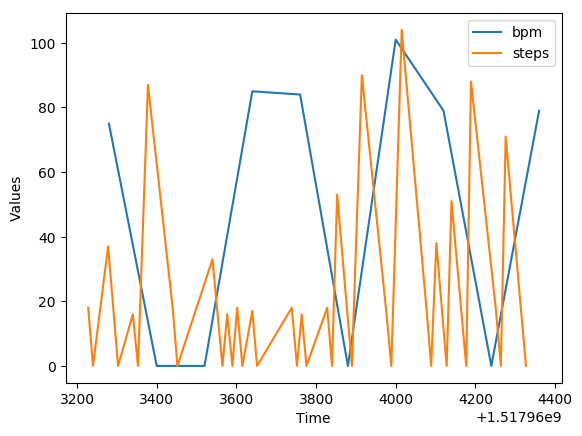

In [132]:
plt.figure()
X = tempBpm['epoch_start_utc']
Y = tempBpm['bpm']
plt.plot(X,Y,label='bpm')
X = tempSteps['step_time']
Y = tempSteps['ind_steps']
plt.plot(X,Y,label='steps')
print(X.values)
#plt.xticks(range(len(X)),X.values,rotation='vertical')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [354]:
tempAct = pd.read_csv('/Users/adgiridhar/Downloads/act-cat_2018_03_13.csv')
tempBpm = pd.read_csv('/Users/adgiridhar/Downloads/bpm-cat_2018_03_13.csv')
user_ = 'Caitlin'

In [355]:
tempSteps = %sql SELECT parse_user_id AS user_id, steps as ind_steps, utc_start_time_epoch AS step_time, utc_start_date AS step_date FROM rawsync.t22_steps_activity WHERE step_date >= '2018-02-04 00:00:00' AND user_id = '61LXTKE4NW' ORDER BY step_time

11510 rows affected.


In [356]:
tempSteps = pd.DataFrame(tempSteps)
tempSteps.columns = ['user_id','ind_steps','step_time','step_date']
tempSteps['step_date'] = pd.to_datetime(tempSteps['step_date'])
#tempSteps

In [357]:
tempBpm['epoch_start_date'] = pd.to_datetime(tempBpm['epoch_start_date'])
tempBpm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10040 entries, 0 to 10039
Data columns (total 5 columns):
user_id             10040 non-null object
epoch_start_utc     10040 non-null int64
bpm                 10040 non-null int64
epoch_start_date    10040 non-null datetime64[ns]
epoch_next_utc      9996 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 392.3+ KB


In [358]:
tempAct['activity_start'] = pd.to_datetime(tempAct['activity_start'])
tempAct['activity_end'] = pd.to_datetime(tempAct['activity_end'])

tempAct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 5 columns):
user_id           146 non-null object
activity_start    146 non-null datetime64[ns]
activity_end      146 non-null datetime64[ns]
cardtype          146 non-null int64
autocreated       146 non-null bool
dtypes: bool(1), datetime64[ns](2), int64(1), object(1)
memory usage: 4.8+ KB


In [359]:
tempAct['duration'] = tempAct['activity_end']-tempAct['activity_start']
def td_to_min(row):
    return (row['duration']/ np.timedelta64(1, 'm')).astype(int)

tempAct['duration'] = tempAct.apply(lambda row:td_to_min(row),axis=1)
#tempAct

In [360]:
def tz_func(row,col):
    #global demo_demo, demo_row
    #demo_demo = row['activity_start']
    #demo_row = row['state_name']
    return row[col].tz_localize('UTC').tz_convert(us.states.lookup('California').time_zones[0])
    
tempAct['local_start'] = tempAct.apply(lambda row:tz_func(row,'activity_start'),axis=1)
#tempAct

In [361]:
def date_(dt_):
    return dt_.date()
tempAct['activity_date'] = tempAct['activity_start'].apply(date_)

In [362]:
condition_ = tempAct['cardtype']==4
tempSleep = tempAct[condition_]
tempSleep = tempSleep.reset_index(drop=True)
tempSleep = tempSleep.sort_values(by=['activity_date','duration'])
tempSleep = tempSleep[tempSleep['duration']>90]
tempSleep = tempSleep.drop_duplicates(['activity_date'])
#tempSleep

In [363]:
def sleepTime_to_RHR(row):
    if row.name%1000 == 0:
        print(row.name,pd.to_datetime('now'))
    user_ = row['user_id']#'CEQ9p1uKqj'
    start_ = row['activity_start']#'2018-02-14 03:51:38'
    end_ = row['activity_end']#'2018-02-14 11:24:02'
    #print(user_,start_,end_)
    #print(sum(pd.to_datetime(start_)<bpmDf_sleep_act['epoch_start_date']))
    condition_ = np.logical_and(pd.to_datetime(start_)<=tempBpm['epoch_start_date'],tempBpm['epoch_start_date']<=pd.to_datetime(end_))   
    reqBPM = tempBpm[condition_]['bpm']
    reqBPM = reqBPM[reqBPM>0]
    RHR = reqBPM.quantile(0.1,interpolation='lower')/.91
    #plt.plot(range(len(reqBPM)),reqBPM)
    #plt.plot([0,len(reqBPM)],[RHR,RHR],"r--")
    return RHR

#plt.figure()
print(sleepTime_to_RHR(tempSleep.iloc[0]))

0 2018-03-14 20:47:18
62.637362637362635


In [364]:
tempSleep['RHR'] = tempSleep.apply(lambda row: sleepTime_to_RHR(row),axis=1)

0 2018-03-14 20:47:18


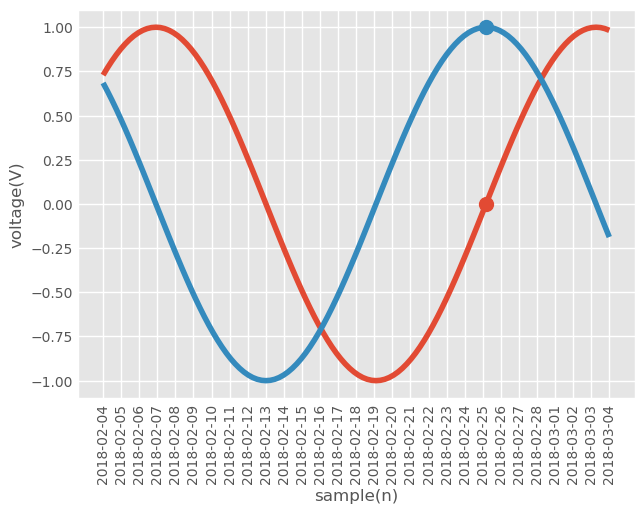

In [597]:
Fs = 200
f = 2
sample = 200
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
y_ = np.cos(2 * np.pi * f * x / Fs)
plt.plot(np.linspace(0,28,len(y[13:13+int(len(y)/2) + 16])),y[13:13+int(len(y)/2) +16], marker='o', markevery=[87],markersize=10)   
plt.plot(np.linspace(0,28,len(y[13:13+int(len(y)/2) + 16])),y_[13:13+int(len(y)/2) +16], marker='o', markevery=[87],markersize=10)   
#plt.plot(46, y[13+46], '-gD', markevery=markers_on)


plt.xticks(range(len(tempSleep['activity_date'])),tempSleep['activity_date'],rotation='vertical')

plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

In [567]:
def smoothTriangle(data, degree, dropVals=False):
    triangle=np.array(list(range(degree)) + [degree] + list(range(degree)[::-1])) + 1
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(sum(point)/sum(triangle))
    if dropVals:
        return smoothed
    #print(type(smoothed),type(smoothed[0]),type(degree),type(degree/2))
    #smoothed=[smoothed[0]*(float(degree) + float(degree)/2)] + smoothed
    while len(smoothed) < len(data):
        smoothed.append(np.nan)
    smoothed = pd.Series(smoothed).interpolate().values
    return smoothed

/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if sys.path[0] == '':
/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


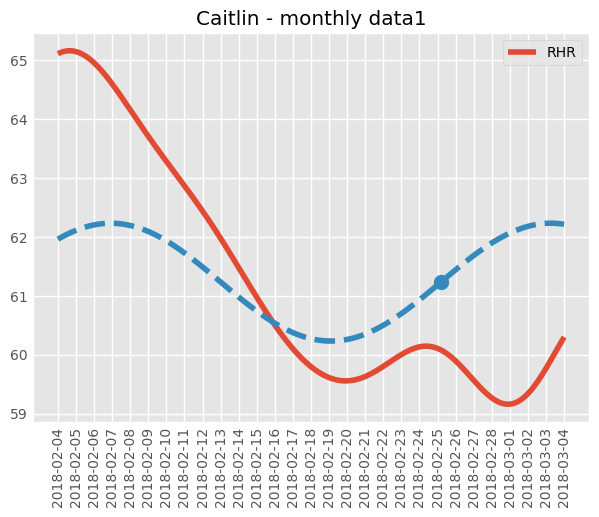

/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


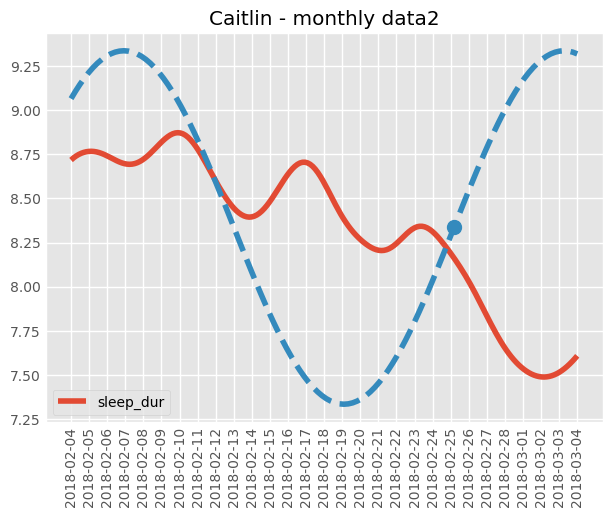

In [629]:
plt.figure()
#tempSleep = tempSleep.set_index('activity_date')
#tempSleep = tempSleep.reindex(pd.date_range('2018-02-04','2018-03-04'))
#tempSleep = tempSleep.reset_index()
tempSleep['activity_date'] = tempSleep['index'].apply(date_)

#plt.bar(range(len(tempSleep['RHR'])),tempSleep['RHR'],label='RHR')
tempDf = tempSleep['RHR'].interpolate().fillna(60)
T = range(0,len(tempDf.values))
xnew = np.linspace(min(T),max(T),len(tempDf.values)*20)
power = list(tempDf.values)
power_smooth = spline(T,power,xnew)
#plt.plot(xnew,power_smooth,label='RHR_old')

#power_smooth = tempDf.values
#xnew = np.linspace(min(T),max(T),len(tempDf.values))

for i in range(len(power_smooth)):
    if power_smooth[i]<0:
        power_smooth[i] = 60


power_smooth  = smoothTriangle(power_smooth,45,dropVals=True)
power_smooth  = smoothTriangle(power_smooth,45,dropVals=True)
#print(power_smooth)
T = range(0,len(power_smooth))
xnew = np.linspace(min(T),max(T),len(power_smooth)*20)
power = list(power_smooth)
power_smooth = spline(T,power,xnew)
xnew = np.linspace(0,28,len(power_smooth))


plt.plot(xnew,power_smooth,label='RHR')
plt.plot(np.linspace(0,28,len(y[13:13+int(len(y)/2) + 16])),y[13:13+int(len(y)/2) +16] + np.mean(power_smooth),linestyle='--', marker='o', markevery=[87],markersize=10)   
plt.xticks(range(len(tempSleep['activity_date'])),tempSleep['activity_date'],rotation='vertical')
plt.title(user_ + ' - monthly data1')
plt.legend()
plt.show()

plt.figure()
#plt.bar(range(len(tempSleep['duration'])),tempSleep['duration']/60,label='sleep_dur')
tempDf = tempSleep['duration'].interpolate().fillna(np.mean(tempSleep['duration'].dropna()))/60
tempDf = tempDf.values
for i in range(len(tempDf)):
    if tempDf[i]<7:
        tempDf[i] = np.mean(tempDf)
T = range(0,len(tempDf))
xnew = np.linspace(min(T),max(T),len(tempDf)*10)
power = list(tempDf)
power_smooth = spline(T,power,xnew)
for i in range(len(power_smooth)):
    if power_smooth[i]<0:
        power_smooth[i] = 0

power_smooth  = smoothTriangle(power_smooth,30,dropVals=True)
#print(power_smooth)
T = range(0,len(power_smooth))
#xnew = np.linspace(min(T),max(T),len(power_smooth)*20)
power = list(power_smooth)
#power_smooth = spline(T,power,xnew)
xnew = np.linspace(0,28,len(power_smooth))

plt.plot(xnew,power_smooth,label='sleep_dur')
plt.plot(np.linspace(0,28,len(y[13:13+int(len(y)/2) + 16])),y[13:13+int(len(y)/2) +16] + np.mean(power_smooth),linestyle='--', marker='o', markevery=[87],markersize=10)
plt.xticks(range(len(tempSleep['activity_date'])),tempSleep['activity_date'],rotation='vertical')
plt.title(user_ + ' - monthly data2')
plt.legend()
plt.show()

In [366]:
tempSteps_c = pd.DataFrame(tempSteps.groupby(['step_date']).sum()['ind_steps'])
tempSteps_c

ind_steps
step_date            
2018-02-05        809
2018-02-06       8919
2018-02-07       6632
2018-02-08       6358
2018-02-09       3347
2018-02-10       4603
2018-02-11       9810
2018-02-12       1848
2018-02-13       6119
2018-02-14      12496
2018-02-15        950
2018-02-16       4553
2018-02-17       2537
2018-02-18       4782
2018-02-19       3712
2018-02-20       1081
2018-02-21       6782
2018-02-22       6729
2018-02-23       4016
2018-02-24       7039
2018-02-25        315
2018-02-26       3533
2018-02-27       4412
2018-02-28       7398
2018-03-01       7797
2018-03-02       5126
2018-03-03       1502
2018-03-05        440
2018-03-06       2447
2018-03-07       5981
2018-03-08       4665
2018-03-09       5461
2018-03-10       8512
2018-03-12       1981

In [ ]:
tempAct_c = pd.DataFrame(tempAct.groupby('activity_date').cardtype.count())
tempAct_c

In [368]:
tempAct_c = tempAct_c.reindex(pd.date_range('2018-02-04','2018-03-04'))
tempAct_c = tempAct_c.reset_index()
tempAct_c['activity_date'] = tempAct_c['index'].apply(date_)
print(tempAct_c)
tempSteps_c = tempSteps_c.reindex(pd.date_range('2018-02-04','2018-03-04'))
tempSteps_c = tempSteps_c.reset_index()
tempSteps_c['step_date'] = tempSteps_c['index'].apply(date_)
print(tempSteps_c)



        index  cardtype activity_date
0  2018-02-04       NaN    2018-02-04
1  2018-02-05       NaN    2018-02-05
2  2018-02-06       5.0    2018-02-06
3  2018-02-07       3.0    2018-02-07
4  2018-02-08       2.0    2018-02-08
5  2018-02-09       3.0    2018-02-09
6  2018-02-10       6.0    2018-02-10
7  2018-02-11       5.0    2018-02-11
8  2018-02-12       4.0    2018-02-12
9  2018-02-13      11.0    2018-02-13
10 2018-02-14      10.0    2018-02-14
11 2018-02-15       4.0    2018-02-15
12 2018-02-16       7.0    2018-02-16
13 2018-02-17       2.0    2018-02-17
14 2018-02-18       NaN    2018-02-18
15 2018-02-19       2.0    2018-02-19
16 2018-02-20       2.0    2018-02-20
17 2018-02-21       6.0    2018-02-21
18 2018-02-22       7.0    2018-02-22
19 2018-02-23       4.0    2018-02-23
20 2018-02-24      11.0    2018-02-24
21 2018-02-25       2.0    2018-02-25
22 2018-02-26       3.0    2018-02-26
23 2018-02-27       4.0    2018-02-27
24 2018-02-28       4.0    2018-02-28
25 2018-03-0

In [374]:
import seaborn as sns

[0.0, 0.0, 7.0999999999999996, 8.0666666666666664, 7.583333333333333, 8.6166666666666671, 9.2666666666666675, 9.2666666666666675, 7.6333333333333337, 8.6666666666666661, 10.016666666666667, 8.4000000000000004, 8.3333333333333339, 7.6166666666666663, 8.8000000000000007, 9.9833333333333325, 7.7833333333333332, 7.7999999999999998, 8.0, 9.2166666666666668, 2.5333333333333332, 5.25, 7.8166666666666664, 7.2999999999999998, 7.3499999999999996, 7.416666666666667, 8.0, 8.0, 8.0] [  0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.46698983
   1.19130749   1.94530603   2.7140242    3.48250073   4.23577438
   4.95888389   5.63686801   6.25476549   6.79761508   7.25064112
   7.60851024   7.87962553   8.07347255   8.19953689   8.2673041
   8.28625974   8.2658894    8.21567862   8.14511299   8.06367801
   7.97957971   7.89642551   7.81679002   7.74324789   7.67837375
   7.62474222   7.58492795   7.56150557   7.55

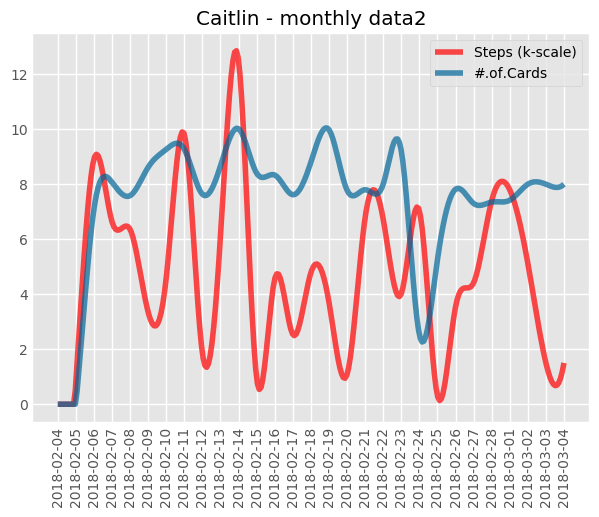

In [490]:
plt.style.use('ggplot')

from scipy.interpolate import spline

#T = range(0,len(tempAct_c['cardtype'].values))
#xnew = np.linspace(min(T),max(T),len(tempAct_c['cardtype'].values))
#power = list(tempAct_c['cardtype'].values)
#power_smooth = spline(T,power,xnew)
for i in range(len(power_smooth)):
    if power_smooth[i]<0:
        power_smooth[i] = 0
for i in range(len(power_smooth1)):
    if power_smooth1[i]<0:
        power_smooth1[i] = 0
print(power,power_smooth)
plt.figure()
#plt.bar(range(len(tempSteps_c['ind_steps'])),tempSteps_c['ind_steps']/1000,label='Steps (k-scale)')
plt.plot(xnew1,power_smooth1,label='Steps (k-scale)',alpha=0.7,color='r')
#plt.plot(xnew,power_smooth,label='#.of.Cards',alpha=0.7,color=(0,0.4,0.6))
plt.plot(xnew,power_smooth,label='#.of.Cards',alpha=0.7,color=(0,0.4,0.6))
#plt.plot(range(len(tempAct_c['cardtype'])),tempAct_c['cardtype'],label='#.of.Cards',alpha=0.7,color=(0,0.4,0.6))
#tempSteps_c = tempSteps_c.reset_index()
plt.xticks(range(len(tempSteps_c['step_date'])),tempSteps_c['step_date'],rotation='vertical')
plt.title(user_ + ' - monthly data2')
plt.legend()
plt.show()


from scipy.interpolate import spline


#barlist = plt.bar(range(len(tempDf.values())-1),list(tempDf.values())[:-1])#,power_smooth)

/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """
/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if sys.path[0] == '':


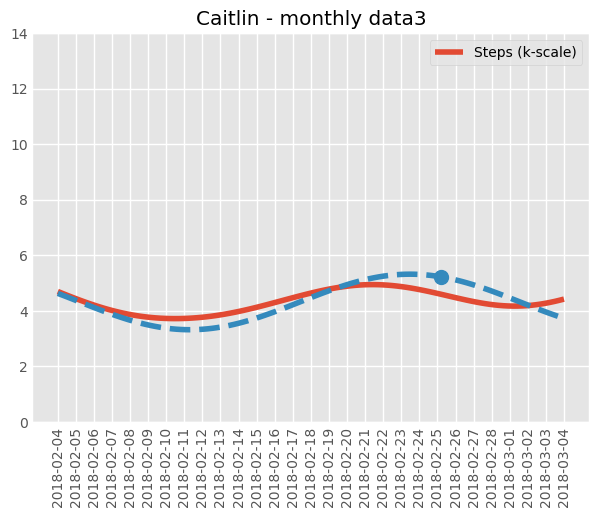

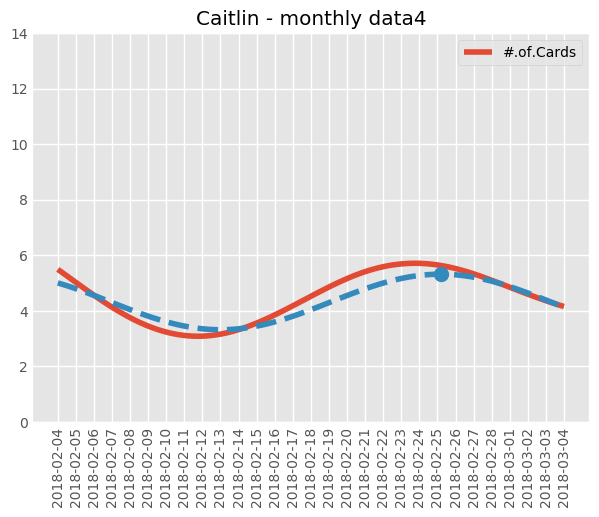

In [625]:
tempDf = tempAct_c['cardtype'].interpolate().fillna(0)
T = range(0,len(tempDf.values))
xnew = np.linspace(min(T),max(T),len(tempDf.values)*10)
power = list(tempDf.values)
power_smooth = spline(T,power,xnew)


tempDf = tempSteps_c['ind_steps'].interpolate().fillna(0)/1000
T = range(0,len(tempDf.values))
xnew1 = np.linspace(min(T),max(T),len(tempDf.values)*10)
power1 = list(tempDf.values)
power_smooth1 = spline(T,power1,xnew1)


plt.figure()

power_smooth1  = smoothTriangle(power_smooth1,30,dropVals=True)
power_smooth1  = smoothTriangle(power_smooth1,30,dropVals=True)
T = range(0,len(power_smooth1))
xnew1 = np.linspace(0,28,len(power_smooth1))

plt.plot(xnew1,power_smooth1,label='Steps (k-scale)')
plt.plot(np.linspace(0,28,len(y[13:13+int(len(y)/2) + 16])),y_[20:20+int(len(y)/2) +16] + np.mean(power_smooth1),linestyle='--', marker='o', markevery=[87],markersize=10)   
#plt.plot(xnew,power_smooth,label='#.of.Cards',alpha=0.7,color=(0,0.4,0.6))
plt.xticks(range(len(tempSteps_c['step_date'])),tempSteps_c['step_date'],rotation='vertical')
plt.title(user_ + ' - monthly data3')
plt.ylim([0,14])
plt.legend()
plt.show()

plt.figure()

power_smooth  = smoothTriangle(power_smooth,30,dropVals=True)
power_smooth  = smoothTriangle(power_smooth,30,dropVals=True)
T = range(0,len(power_smooth))
xnew = np.linspace(0,28,len(power_smooth))

plt.plot(xnew,power_smooth,label='#.of.Cards')
plt.plot(np.linspace(0,28,len(y[13:13+int(len(y)/2) + 16])),y_[13:13+int(len(y)/2) +16] + np.mean(power_smooth1),linestyle='--', marker='o', markevery=[87],markersize=10)   
#plt.plot(range(len(tempAct_c['cardtype'])),tempAct_c['cardtype'],label='#.of.Cards',alpha=0.7,color=(0,0.4,0.6))
#tempSteps_c = tempSteps_c.reset_index()
plt.xticks(range(len(tempSteps_c['step_date'])),tempSteps_c['step_date'],rotation='vertical')
plt.title(user_ + ' - monthly data4')
plt.ylim([0,14])
plt.legend()
plt.show()

/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


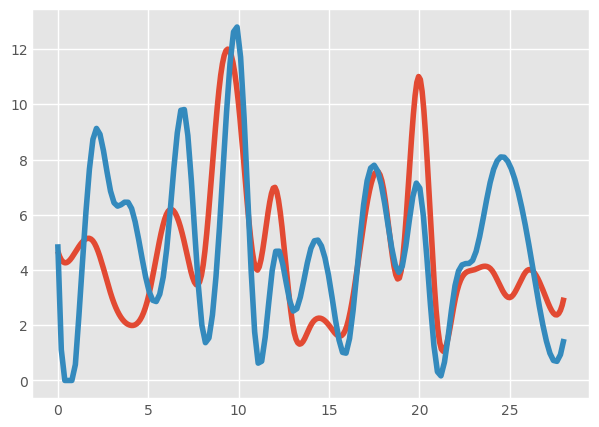

In [513]:
plt.figure()


tempDf = tempAct_c['cardtype'].interpolate().fillna(np.mean(tempAct_c['cardtype'].dropna()))
T = range(0,len(tempDf.values))
xnew = np.linspace(min(T),max(T),len(tempDf.values)*10)
power = list(tempDf.values)
power_smooth = spline(T,power,xnew)

#plt.plot(range(len(tempAct_c['cardtype'])),tempAct_c['cardtype'])
plt.plot(xnew,power_smooth)

tempDf = tempSteps_c['ind_steps'].interpolate().fillna(np.mean(tempSteps_c['ind_steps'].dropna()))/1000
#print(tempDf)

T = range(0,len(tempDf.values))
xnew1 = np.linspace(min(T),max(T),len(tempDf.values)*5)
power1 = list(tempDf.values)
power_smooth1 = spline(T,power1,xnew1)
for i in range(len(power_smooth1)):
    if power_smooth1[i]<0:
        power_smooth1[i] = 0
#print(power_smooth1)


plt.plot(xnew1,power_smooth1)
plt.show()

/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if __name__ == '__main__':
/Users/adgiridhar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


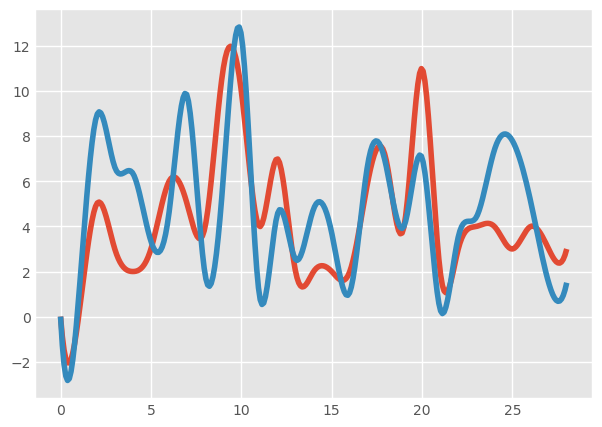

In [617]:
plt.figure()


#print(tempAct_c['cardtype'].interpolate().fillna(0))
tempDf = tempAct_c['cardtype'].interpolate().fillna(0)
T = range(0,len(tempDf.values))
xnew = np.linspace(min(T),max(T),len(tempDf.values)*10)
power = list(tempDf.values)
power_smooth = spline(T,power,xnew)

#plt.plot(range(len(tempAct_c['cardtype'])),tempAct_c['cardtype'])
plt.plot(xnew,power_smooth)

tempDf = tempSteps_c['ind_steps'].interpolate().fillna(0)/1000
T = range(0,len(tempDf.values))
xnew1 = np.linspace(min(T),max(T),len(tempDf.values)*10)
power1 = list(tempDf.values)
power_smooth1 = spline(T,power1,xnew1)



plt.plot(xnew1,power_smooth1)
plt.show()

In [510]:
spline

<function numpy.lib.utils._Deprecate.__call__.<locals>.newfunc>